In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from graphviz import Source

In [49]:
class DSU:
    def __init__(self,items):
        self._dsu=[[i] for i in set(items)]

    def _get_index(self,state):
        for s in self._dsu:
            for i in s:
                if i==state:
                     return self._dsu.index(s)

        return None
        
    def find(self,node):
        for s in self._dsu:
            if node in s:
                return s
        return None

    def find_set(self,node):
        s=self._get_index(node)
        return s+1 if s is not None else None
        
    def union(self,state1,state2):
        s1,s2=self._get_index(state1),self._get_index(state2)
        if s1!=s2:
            self._dsu[s1]+=self._dsu[s2]
            del self._dsu[s2]
            print(self.get())

    def get(self):
        return self._dsu

class DFA:
    def __init__(self,input_file):
        self._generate_graph(input_file)

    def _generate_graph(self,input_file):
        f=open(input_file)
        lines=f.readlines()
        lines[-1]+="\n"
        
        states,alphabet,start_state,final_states=lines[:4]
        
        self.states=states[:-1].split()
        self.alphabet=alphabet[:-1].split()
        self.start_state=start_state[:-1]
        self.final_states=final_states[:-1].split()

        self.dead_states=[]
        self.transitions={}

        for line in lines[4:]:
            current_state,symbol,next_state=line[:-1].split()
            self.transitions[(current_state,symbol)]=next_state

    def _remove_unreachable_states(self):
        graph=defaultdict(list)
        for transition in self.transitions:
            source_state=transition[0]
            destination_state=self.transitions[transition]
            graph[source_state].append(destination_state)

        stack=[self.start_state]  #DFS
        visited=set()
        while stack:
            state=stack.pop()
            if state not in visited:
                stack+=graph[state]
            visited.add(state)

        self.dead_states=[state for state in self.states if state not in visited]
        self.states=list(visited)
        self.final_states=[state for state in self.final_states if state in visited]
        
            
        needed_transitions={}
        for transition in self.transitions:
            if transition[0] in visited:
                needed_transitions[transition]=self.transitions[transition]

        self.transitions=needed_transitions

    def minimize(self):
        self._remove_unreachable_states()
        table={}

        sorted_states=sorted(self.states)

        #Make the final and non-final initial sets
        for idx,state1 in enumerate(sorted_states):
            for state2 in sorted_states[idx+1:]:
                table[(state1,state2)]= (state1 not in self.final_states)!=(state2 not in self.final_states) 
                #The true/false value indicates if state1 and state2 belong to the same set
                #True indicates different set

        flag=True
        while flag:
            flag=False

            for idx,state1 in enumerate(sorted_states):
                for state2 in sorted_states[idx+1:]:
                    if table[(state1,state2)]:
                        continue #What to do,they are in different sets

                    for symbol in self.alphabet:
                        bool1=self.transitions.get((state1,symbol))
                        bool2=self.transitions.get((state2,symbol))

                        if bool1 is not None and bool2 is not None and bool1!=bool2:
                            key=(bool1,bool2)
                            if bool2<bool1:
                                key=(bool2,bool1)

                            flag2=table[key]
                            table[(state1,state2)]=flag2
                            flag=flag or flag2

                            if flag2:
                                break    #If flag2 is true it means that the transitions lead to states that are in different sets.
                                         #So their behaviour is different,no point checking further with other symbols.Break off
        
                
        dsu=DSU(self.states)

        for key in table:
            if not table[key]:
                dsu.union(key[0],key[1])

        self.states=[str(i) for i in range(1,1+len(dsu.get()))]
        new_finals=[]
        self.start_state=str(dsu.find_set(self.start_state))

        for state in dsu.get():
            for item in state:
                if item in self.final_states:
                    new_finals.append(str(dsu.find_set(item)))
                    break
        print(dsu.get())
        new_transitions={}
        for key,value in self.transitions.items():
            new_curr_state=str(dsu.find_set(key[0]))
            symbol=key[1]
            new_next_state=str(dsu.find_set(value))
            new_transitions[(new_curr_state,symbol)]=new_next_state

        self.transitions=new_transitions
        self.final_states=new_finals


    def plot(self):
        graph=nx.DiGraph()
        for state in self.states:
            if state in self.final_states:
                if state==self.start_state:
                    graph.add_node(state,shape="doublecircle",fillcolor="yellow")
                else:
                    graph.add_node(state,shape="doublecircle")
            else:
                graph.add_node(state,shape="circle")

        edges=defaultdict(list)
        for key,value in self.transitions.items():
            edges[(key[0],value)].append(key[1])
    
        for key,value in edges.items():
            graph.add_edge(key[0],key[1],label=",".join(value))

        pos=nx.spring_layout(graph)
        nx.draw(graph,pos,with_labels=True,node_size=2000,arrows=True)
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edges)
        nx.draw_networkx_nodes(graph, pos, nodelist=[self.start_state], node_color='lightgreen', node_size=2000)
        nx.draw_networkx_nodes(graph, pos, nodelist=self.final_states, node_color='yellow', node_size=2000)

        plt.show()

In [3]:
#Eg below copied from GFG

In [32]:
dfa=DFA("DFA_Input.txt")

In [33]:
dfa.transitions

{('1', 'a'): '4',
 ('4', 'a'): '1',
 ('1', 'b'): '2',
 ('2', 'a'): '3',
 ('3', 'a'): '3',
 ('3', 'b'): '6',
 ('6', 'a'): '6',
 ('6', 'b'): '6',
 ('5', 'b'): '6',
 ('5', 'a'): '3',
 ('2', 'b'): '6',
 ('4', 'b'): '5'}

In [34]:
dfa.final_states

['2', '3', '5']

In [35]:
dfa.states

['1', '2', '3', '4', '5', '6']

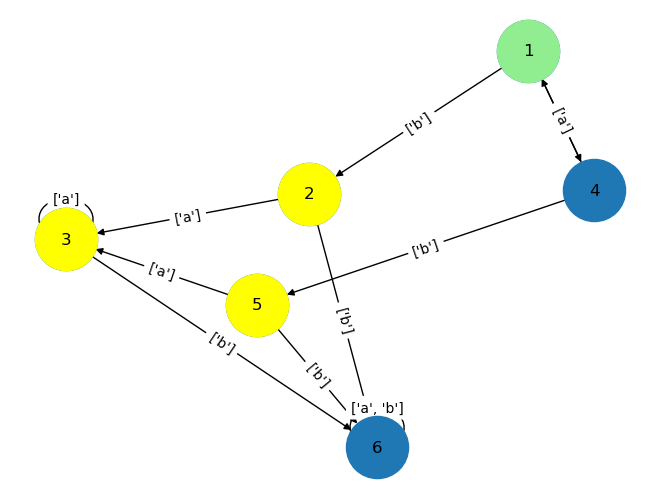

In [36]:
dfa.plot()

In [37]:
dfa.minimize()

[['2'], ['6'], ['5'], ['3'], ['1', '4']]
[['2', '3'], ['6'], ['5'], ['1', '4']]
[['2', '3', '5'], ['6'], ['1', '4']]
[['2', '3', '5'], ['6'], ['1', '4']]


In [38]:
dfa.dead_states

[]

In [39]:
dfa.transitions

{('3', 'a'): '3',
 ('3', 'b'): '1',
 ('1', 'a'): '1',
 ('1', 'b'): '2',
 ('2', 'a'): '2',
 ('2', 'b'): '2'}

In [40]:
dfa.states

['1', '2', '3']

In [41]:
dfa.final_states

['1']

In [42]:
dfa.start_state

'3'

In [43]:
dfa.transitions

{('3', 'a'): '3',
 ('3', 'b'): '1',
 ('1', 'a'): '1',
 ('1', 'b'): '2',
 ('2', 'a'): '2',
 ('2', 'b'): '2'}

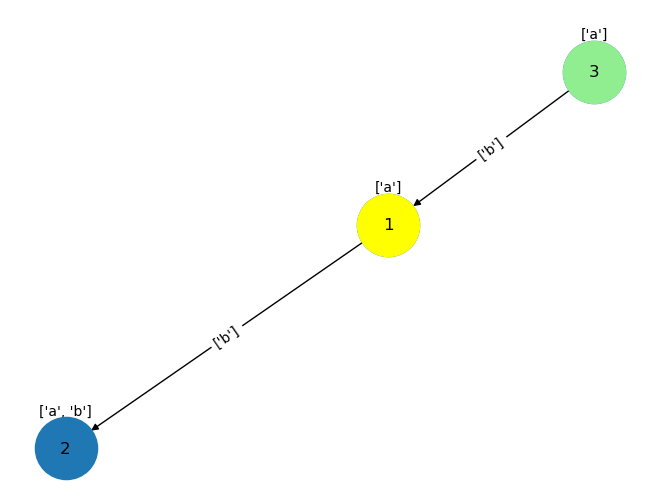

In [44]:
dfa.plot()

In [61]:
dfa2=DFA("DFA_Input2.txt")

In [62]:
dfa2.transitions

{('1', 'a'): '2',
 ('2', 'a'): '1',
 ('3', 'a'): '2',
 ('3', 'b'): '5',
 ('5', 'a'): '4',
 ('5', 'b'): '4',
 ('4', 'a'): '6',
 ('4', 'b'): '6',
 ('6', 'a'): '6',
 ('6', 'b'): '6',
 ('1', 'b'): '4',
 ('2', 'b'): '4'}

In [63]:
dfa2.final_states,dfa2.start_state

(['4', '6'], '1')

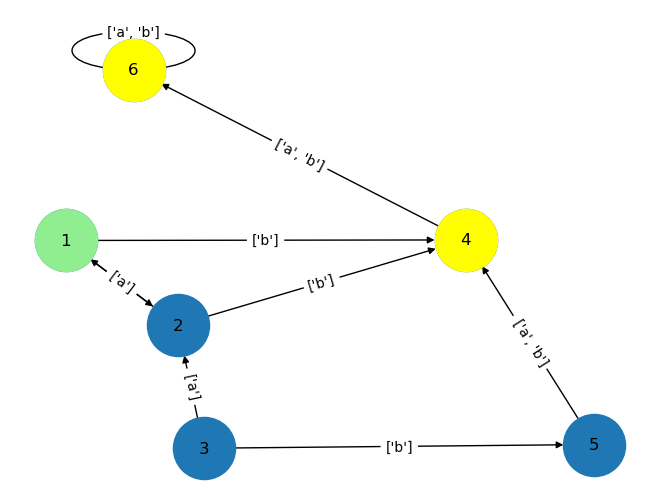

In [65]:
dfa2.plot()

In [66]:
dfa2.minimize()

[['6'], ['1', '2'], ['4']]
[['1', '2'], ['4', '6']]
[['1', '2'], ['4', '6']]


In [67]:
dfa2.dead_states

['3', '5']

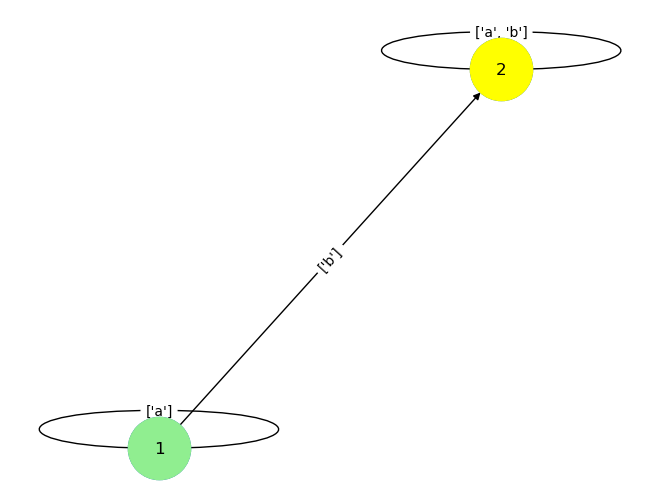

In [68]:
dfa2.plot()